Ratings Loaded: (100836, 4) (Rows, Cols)
Movies Loaded: (9742, 3) (Rows, Cols)

Merged Dataset Sample:


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


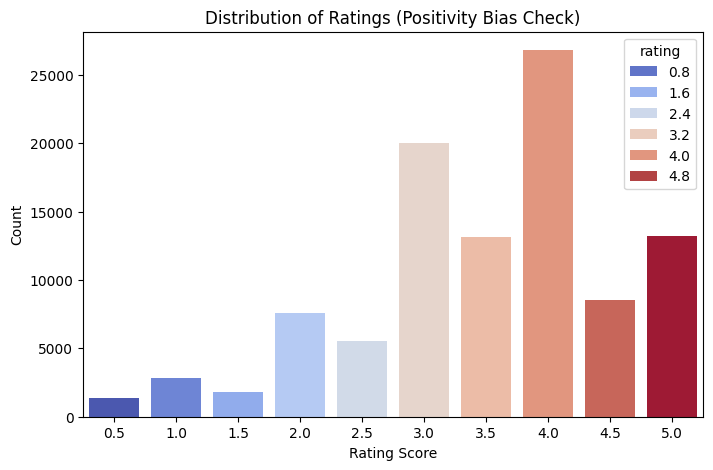


Top 5 Most Rated Movies:
title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64


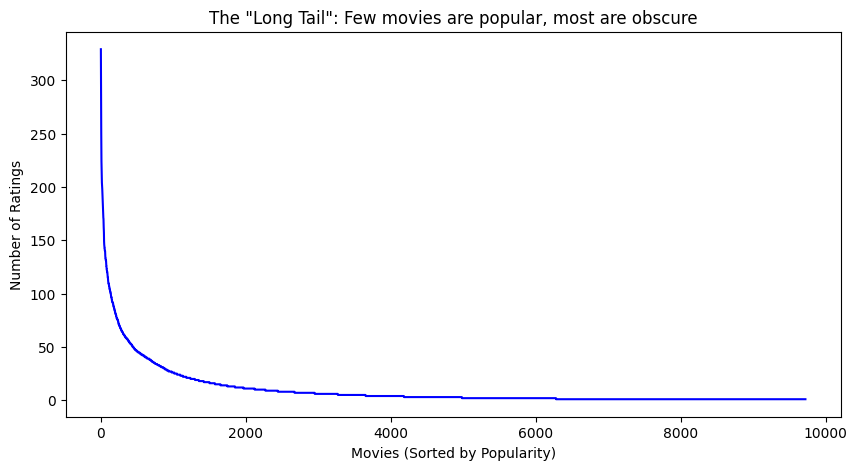

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  STEP 1: LOAD THE DATA 
# We load the two main CSV files
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')

print(f"Ratings Loaded: {ratings.shape} (Rows, Cols)")
print(f"Movies Loaded: {movies.shape} (Rows, Cols)")

#  STEP 2: MERGE DATA 
# We join them on 'movieId' so we can see titles instead of numbers
df = pd.merge(ratings, movies, on='movieId')
print("\nMerged Dataset Sample:")
display(df.head())

#  STEP 3: EXPLORATORY DATA ANALYSIS (EDA) 

# A. Rating Distribution (Positivity Bias)
# Question: Do people give mostly 5s or 1s?
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df,hue="rating", palette='coolwarm')
plt.title('Distribution of Ratings (Positivity Bias Check)')
plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.show()

# B. The Long Tail (Popularity Check)
# Question: Which movies have the most ratings?
movie_stats = df.groupby('title')['rating'].count().sort_values(ascending=False)
print("\nTop 5 Most Rated Movies:")
print(movie_stats.head())

# Plot the Long Tail
plt.figure(figsize=(10, 5))
plt.plot(movie_stats.values, color='blue')
plt.title('The "Long Tail": Few movies are popular, most are obscure')
plt.xlabel('Movies (Sorted by Popularity)')
plt.ylabel('Number of Ratings')
plt.show()

In [6]:
#merging the datasets to show user, movie name, and rating
df = pd.merge(ratings, movies, on='movieId')
print("Merged Data (User + Movie Name + Rating):")
display(df[['userId', 'title', 'rating', 'genres']].head())

Merged Data (User + Movie Name + Rating):


,userId,title,rating,genres
0,1,Toy Story (1995),4.0,Adventure|Animation|Children|Comedy|Fantasy
1,1,Grumpier Old Men (1995),4.0,Comedy|Romance
2,1,Heat (1995),4.0,Action|Crime|Thriller
3,1,Seven (a.k.a. Se7en) (1995),5.0,Mystery|Thriller
4,1,"Usual Suspects, The (1995)",5.0,Crime|Mystery|Thriller


In [1]:
#  STEP 4: PREPROCESSING (FILTERING) 

# Filter 1: Remove movies with fewer than 10 ratings
min_movie_ratings = 100
filter_movies = movie_stats[movie_stats >= min_movie_ratings].index

# Keep only the popular movies
df_clean = df[df['title'].isin(filter_movies)]

print(f"\nOriginal Unique Movies: {df['title'].nunique()}")
print(f"Cleaned Unique Movies: {df_clean['title'].nunique()}")
print(f"We removed {df['title'].nunique() - df_clean['title'].nunique()} noise movies.")

NameError: name 'movie_stats' is not defined

In [8]:
#  STEP 5: CREATING THE SPARSE MATRIX 

# Create a Pivot Table
# Index (Rows) = Users
# Columns = Movies
# Values = Ratings
user_item_matrix = df_clean.pivot_table(index='userId', columns='title', values='rating')

# Fill NaNs with 0 (kNN needs numbers, not "Empty")
user_item_matrix.fillna(0, inplace=True)

# Check the shape
print("\nUser-Item Matrix Shape:", user_item_matrix.shape)
print("Transformation Complete. Data is ready for the Model.")

# Show a small sample (First 5 users, First 5 movies)
display(user_item_matrix.iloc[:5, :5])


User-Item Matrix Shape: (610, 2269)
Transformation Complete. Data is ready for the Model.


title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)"
userId,,,,,
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0


In [9]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# STEP 1: TRANSFORMATION (DATAFRAME -> MATRIX) 
user_item_matrix = df_clean.pivot_table(index='userId', columns='title', values='rating')

user_item_matrix.fillna(0, inplace=True)
user_item_sparse = csr_matrix(user_item_matrix.values)

print(f"Matrix Created. Shape: {user_item_matrix.shape}")
print("Ready for Training.")

#  STEP 2: TRAINING THE KNN MODEL 
# Metric = 'cosine' (Measure the Angle)
# Algorithm = 'brute' (Standard for sparse data)
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

knn_model.fit(user_item_sparse.T)

print(" Model Trained Successfully!")

Matrix Created. Shape: (610, 2269)
Ready for Training.
 Model Trained Successfully!


In [1]:
#  STEP 3: DEFINE THE RECOMMENDATION FUNCTION 


def get_recommendations(movie_name, n_recommendations=5):
    # 1. Check if movie exists
    if movie_name not in user_item_matrix.columns:
        return f"Error: Movie '{movie_name}' not found in dataset."

    # 2. Get the vector for this movie
    
    movie_index = user_item_matrix.columns.get_loc(movie_name)
    movie_vector = user_item_matrix.iloc[:, movie_index].values.reshape(1, -1)

    # 3. Ask the model for neighbors
    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=n_recommendations+1)

    # 4. Print the results
    print(f"\nBecause you watched '{movie_name}':")
    for i in range(1, len(distances.flatten())):
        idx = indices.flatten()[i]
        dist = distances.flatten()[i]
        
        # Convert Index back to Title
        similar_movie = user_item_matrix.columns[idx]
        
        # Convert Distance to Similarity Score (1 - distance)
        similarity_score = 1 - dist
        print(f"{i}. {similar_movie} (Similarity: {similarity_score:.2%})")

In [17]:

# Note: You must use the EXACT title string from the dataset (Case sensitive!)
get_recommendations('Dracula: Dead and Loving It (1995)')


Because you watched 'Dracula: Dead and Loving It (1995)':
1. All Dogs Go to Heaven 2 (1996) (Similarity: 44.18%)
2. Jack (1996) (Similarity: 43.24%)
3. Space Jam (1996) (Similarity: 41.69%)
4. Homeward Bound II: Lost in San Francisco (1996) (Similarity: 39.11%)
5. Tales from the Crypt Presents: Bordello of Blood (1996) (Similarity: 38.88%)


In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error
import math

# STEP 5: EVALUATE (CALCULATE RMSE) 

def predict_rating(user_id, movie_title):
    # 1. Check if movie and user exist in our matrix
    if movie_title not in user_item_matrix.columns or user_id not in user_item_matrix.index:
        return 3.5 # Fallback to global average if unknown (Cold Start)

    # 2. Get the vector for the target movie
    movie_index = user_item_matrix.columns.get_loc(movie_title)
    movie_vector = user_item_matrix.iloc[:, movie_index].values.reshape(1, -1)

    # 3. Find k=20 Neighbors for this movie
    # We ask for 21 because the first one is always the movie itself
    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=21)

    # 4. Calculate Weighted Average of Neighbors' Ratings
    sum_similarity = 0
    weighted_ratings = 0
    
    for i in range(1, len(distances.flatten())):
        idx = indices.flatten()[i]
        sim = 1 - distances.flatten()[i] # Convert Distance to Similarity
        
        # Get the neighbor's title
        neighbor_title = user_item_matrix.columns[idx]
        
        rating = user_item_matrix.loc[user_id, neighbor_title]
        
        if rating > 0: 
            weighted_ratings += (sim * rating)
            sum_similarity += sim
            
    # If user hasn't seen ANY neighbors, return average
    if sum_similarity == 0:
        return 3.5 
        
    return weighted_ratings / sum_similarity

# RUN THE TEST 
print("Calculating RMSE on a sample of 100 ratings")

# 1. Pick 100 random actual ratings from the clean dataset
sample = df_clean.sample(100, random_state=42)
y_true = []
y_pred = []

# 2. Loop through and predict
for index, row in sample.iterrows():
    actual = row['rating']
    predicted = predict_rating(row['userId'], row['title'])
    
    y_true.append(actual)
    y_pred.append(predicted)

# 3. Calculate RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)

print(f"Final RMSE Score: {rmse:.4f}")

Calculating RMSE on a sample of 100 ratings
Final RMSE Score: 0.9583
